In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import polars as pl

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics
from src.IDs import *


# Mix high-conf SNPs and two-sided single nuc mismatches

## Get mismatches

In [4]:
def do_it_all(focal_sample_id, denovo_chrom):
    filtered_high_conf_mismatches_df = pl.scan_parquet(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.high_confidence_snps.parquet")
    
    
    filtered_high_conf_mismatches_df = diagnostics.add_high_confidence_annotation(
        filtered_high_conf_mismatches_df,
        base_qual_min = 0, # Don't filter on this just yet
    )
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.filter("is_high_conf_event")
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.collect(streaming=True)
    
    #
    # 3. Find mismatches supported by flanking high conf SNPs (putative GC)
    #
    def F(df):
        df = (df
            .with_columns(
                pl.col("fits1").cum_sum().alias("fits1_before"),
                pl.col("fits1").cum_sum(reverse=True).alias("fits1_after"),
                pl.col("fits2").cum_sum().alias("fits2_before"),
                pl.col("fits2").cum_sum(reverse=True).alias("fits2_after"),
            )
        )
        return df

    context_df = (filtered_high_conf_mismatches_df
        .with_columns(
            (pl.col("op1") == 7).alias("fits1").cast(int),
            (pl.col("op2") == 7).alias("fits2").cast(int),
        )
        .sort("start")
        .group_by("read_name")    
        .map_groups(F)
    )
    
    #
    # 4. Calculate stats
    # 
    flanking = 3

    # Filter for putative GC events
    putative_gc_df_hap = pl.concat(
        [
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("fits1_before") >= flanking) & (pl.col("fits1_after") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("fits2_before") >= flanking) & (pl.col("fits2_after") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
            ),
        ]
    )
    
    # Mark where there are two different SNPs
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns((pl.col("refseq_start1") != pl.col("refseq_start2")).alias("diff_in_haplotypes"))
    )
    
    # Make the three categories
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns(
            pl.when(pl.col('diff_in_haplotypes') & pl.col("other_op_equal")).then(pl.lit("x_vs_y/x"))
              .when(pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/z"))
              .when(~pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/y"))
              .otherwise(pl.lit("x_vs_x/x"))
              .alias('category')
        )
    )
    
    to_round = 1
    putative_gc_df_hap_cnt = (putative_gc_df_hap
        .with_columns(
            (pl.col("qual_start1") // to_round * to_round).alias("qual_rounded"),
        )
        .group_by(["qual_rounded", "category"])
        .count()
        .pivot(
            values=["count"],
            index=["qual_rounded"],
            columns=["category"],
            aggregate_function="sum",
        )
        .fill_null(0)
        .sort("qual_rounded")
        .with_columns(
            pl.lit(focal_sample_id).alias("focal_sample_id"),
            pl.lit(denovo_chrom).alias("chrom"),
        )
    )
    
    return putative_gc_df_hap_cnt
    
    

# Get them all

In [5]:
%%time 
# dfs = []
# for chrom in aut_chrom_names[1:2]:
#     print(chrom)
#     dfs.append(do_it_all(focal_sample_id, chrom + "_RagTag"))
dfs = joblib.Parallel(n_jobs=8, verbose=50)(
    joblib.delayed(do_it_all)(focal_sample_id, chrom + "_RagTag") \
    for chrom in aut_chrom_names \
    for focal_sample_id in ["PD47269d"]
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed: 10.5min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed: 11.3min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed: 12.1min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed: 12.5min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed: 13.2min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed: 14.1min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed: 16.2min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   8 out of  22 | elapsed: 16.6min remaining: 29.0min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   9 out of  22 | elapsed: 18.3min remaining: 26.4min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  10 out of  22 | elapsed: 19.9min remaining: 23.9min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  11 out of  22 | elapsed: 20.1min remaining: 20.1min


/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed: 20.3min remaining: 16.9min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  13 out of  22 | elapsed: 20.7min remaining: 14.4min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  14 out of  22 | elapsed: 21.0min remaining: 12.0min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  15 out of  22 | elapsed: 21.5min remaining: 10.0min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  16 out of  22 | elapsed: 22.4min remaining:  8.4min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed: 22.8min remaining:  6.7min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  18 out of  22 | elapsed: 22.8min remaining:  5.1min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  19 out of  22 | elapsed: 23.3min remaining:  3.7min
[Parallel(n_jobs=8)]: Done  20 out of  22 | elapsed: 23.3min remaining:  2.3min


/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_3998630/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed: 23.6min finished
CPU times: user 1.42 s, sys: 571 ms, total: 1.99 s
Wall time: 23min 36s


# Plotting 

In [6]:
def plot_per_condition(dfs, ax, condition=None):
    if condition is None:
        condition = pl.lit(True)
        
    putative_gc_df_hap_cnt = (
        pl.concat([x.filter(condition)[["qual_rounded", "x_vs_y/y", "x_vs_y/z", "x_vs_y/x"]] for x in dfs])
        .group_by(["qual_rounded"])
        .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/z").sum(), pl.col("x_vs_y/x").sum())
        .sort("qual_rounded")
    )
    
    import statsmodels.stats.proportion
    A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"][::-1])[::-1]
    B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"][::-1])[::-1]
    p = A / B 
    lo, hi = statsmodels.stats.proportion.proportion_confint(
        A, B,
        method="beta", 
        alpha=0.05
    )

    ax.errorbar(
        x = putative_gc_df_hap_cnt["qual_rounded"],
        y = p,
        yerr = [p-lo, hi-p],
        fmt = '.'
    )

    ax.axhline(0.01, ls="--", lw=0.5, c="black")
    ax.axhline(0.1, ls="--", lw=0.5, c="black")

    ax.set_xlabel("BQ (lower threshold)");
    ax.set_ylabel("Estimated false positive rate");
    ax.set_yscale("log")
    #plt.ylim(0.95,1);


    
    

## All

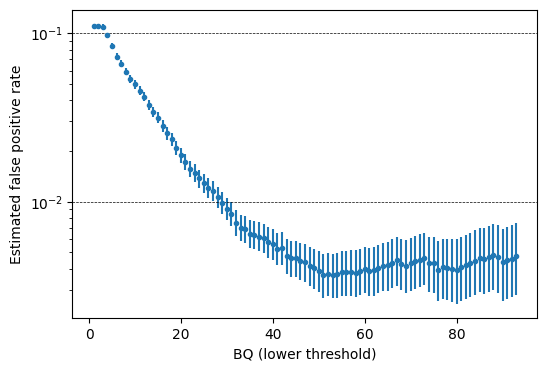

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))

plot_per_condition(dfs, ax, condition=None)

## Per sample

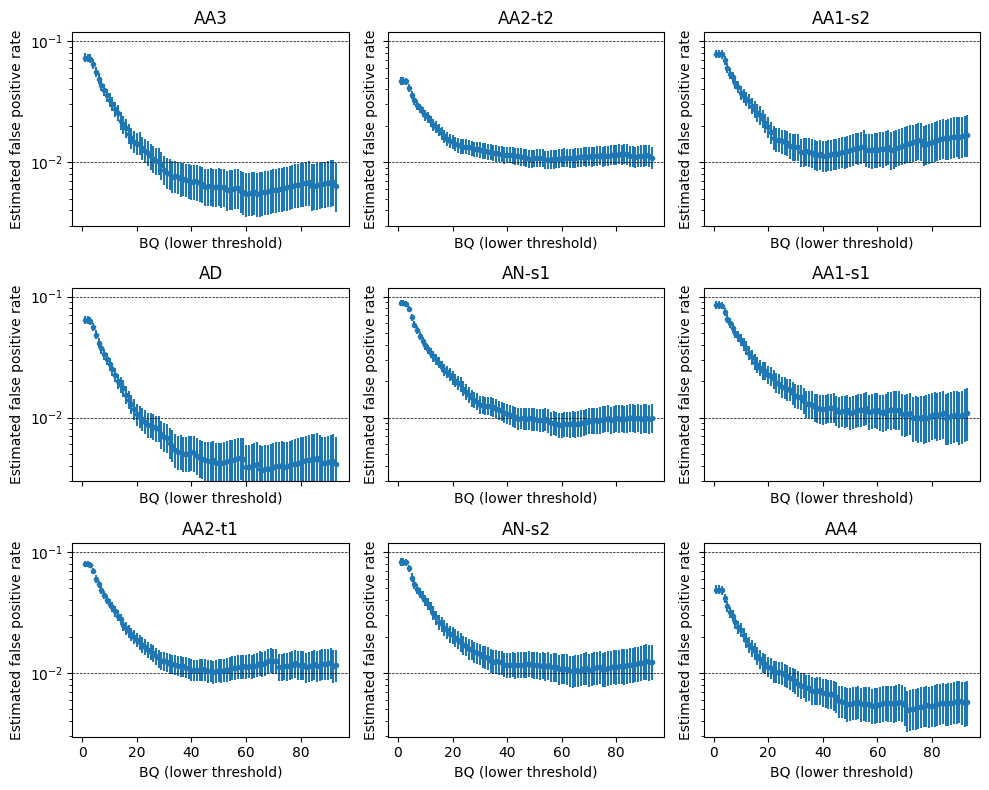

In [57]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()):
    plot_per_condition(dfs, ax, condition=(pl.col("focal_sample_id") == rahbari_sample_ids[i]))
    ax.set_title(sample_id_to_paper_label[rahbari_sample_ids[i]])

plt.tight_layout()

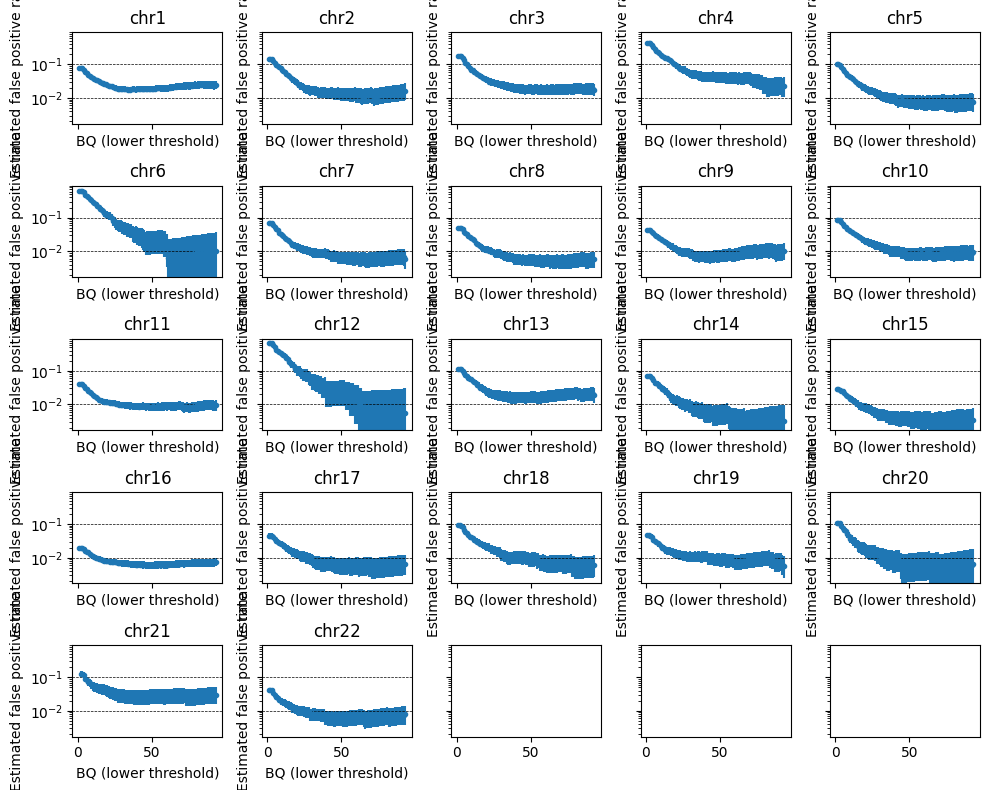

In [62]:
fig, axs = plt.subplots(5, 5, figsize=(10, 8), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()[:len(aut_chrom_names)]):
    plot_per_condition(dfs, ax, condition=(pl.col("chrom") == aut_chrom_names[i] + "_RagTag"))
    ax.set_title(aut_chrom_names[i])

plt.tight_layout()

# Plot it all

In [8]:
%%time
putative_gc_df_hap_cnt = (
    pl.concat([x[["qual_rounded", "x_vs_y/y", "x_vs_y/z", "x_vs_y/x"]] for x in dfs])
    .group_by(["qual_rounded"])
    .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/z").sum(), pl.col("x_vs_y/x").sum())
    .sort("qual_rounded")
)



CPU times: user 13.1 ms, sys: 0 ns, total: 13.1 ms
Wall time: 2.6 ms


In [9]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    display(putative_gc_df_hap_cnt)

qual_rounded,x_vs_y/y,x_vs_y/z,x_vs_y/x
u8,u32,u32,u32
1,97,0,1
2,32228,48,130
3,334310,480,1379
4,347396,490,1438
5,236724,368,1069
6,178199,216,756
7,138817,202,610
8,117574,168,537
9,99264,108,493


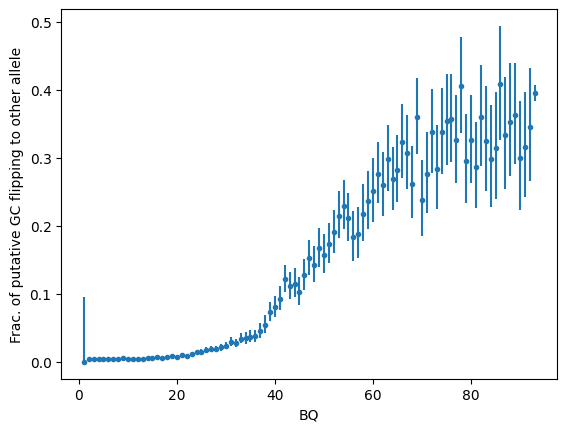

In [27]:
import statsmodels.stats.proportion

A = putative_gc_df_hap_cnt["x_vs_y/x"]
B = putative_gc_df_hap_cnt["x_vs_y/x"] + putative_gc_df_hap_cnt["x_vs_y/z"] + putative_gc_df_hap_cnt["x_vs_y/y"]
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ");
plt.ylabel("Frac. of putative GC flipping to other allele");
#plt.ylim(0,1);


/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/statsmodels/stats/proportion.py:191: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a


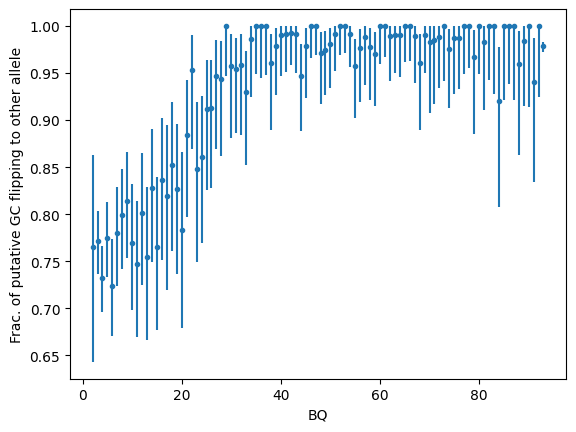

In [28]:
import statsmodels.stats.proportion

A = putative_gc_df_hap_cnt["x_vs_y/x"]
B = putative_gc_df_hap_cnt["x_vs_y/x"] + putative_gc_df_hap_cnt["x_vs_y/z"] 
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ");
plt.ylabel("Frac. of putative GC flipping to other allele");
#plt.ylim(0,1);


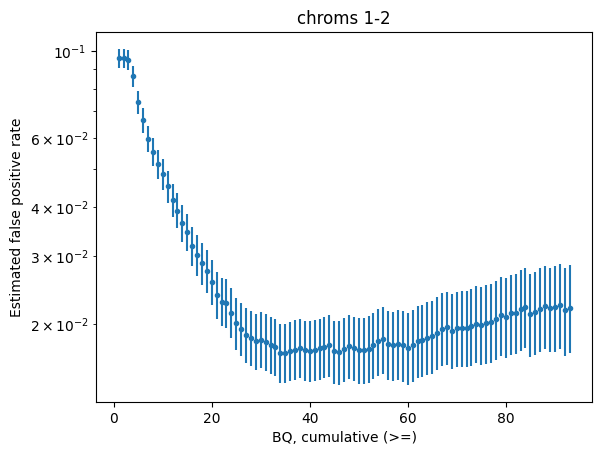

In [30]:
import statsmodels.stats.proportion

A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"][::-1])[::-1]
B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"][::-1])[::-1]
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ, cumulative (>=)");
plt.ylabel("Estimated false positive rate");
plt.yscale("log")
plt.title("chroms 1-2");
#plt.ylim(0.95,1);


# BQ as distance from start/end of read

## Read length

In [12]:
def get_read_lengths(focal_sample_id, denovo_chrom):
    filtered_high_conf_mismatches_df = pl.scan_parquet(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.high_confindence_snps.parquet")

    read_lengths = filtered_high_conf_mismatches_df.unique(["read_name"]).select("read_length1")

    read_lengths = read_lengths.collect(streaming=True)
    
    return read_lengths


In [13]:
sample_id = "PD50477f"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

FileNotFoundError: No such file or directory (os error 2): .../02.chromosome_length_scaffolds/PD50477f/reads/chr1_RagTag.high_confindence_snps.parquet

In [ ]:
sample_id = "PD50489e"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD50521b"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD50519d"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD50508f"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD50523b"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD46180c"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD50521e"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD50508b"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

## Errors at read ends

In [ ]:
def do_it_all_start(focal_sample_id, denovo_chrom):
    filtered_high_conf_mismatches_df = pl.scan_parquet(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.high_confindence_snps.parquet")
    
    
    filtered_high_conf_mismatches_df = diagnostics.add_high_confidence_annotation(
        filtered_high_conf_mismatches_df,
        base_qual_min = 0, # Don't filter on this just yet
    )
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.filter("is_high_conf_event")
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.collect(streaming=True)
    
    #
    # 3. Find mismatches supported by flanking high conf SNPs (putative GC)
    #
    def F(df):
        df = (df
            .with_columns(
                pl.col("fits1").cum_sum().alias("fits1_before"),
                pl.col("fits1").cum_sum(reverse=True).alias("fits1_after"),
                pl.col("fits2").cum_sum().alias("fits2_before"),
                pl.col("fits2").cum_sum(reverse=True).alias("fits2_after"),
                pl.col("start").cum_count().alias("snp_index"),
                pl.col("start").cum_count(reverse=True).alias("snp_rev_index"),
            )
        )
        return df

    min_mapq = 93
    context_df = (filtered_high_conf_mismatches_df
        .filter((pl.col("qual_start1") >= min_mapq) & (pl.col("qual_start2") >= min_mapq))
        .with_columns(
            (pl.col("op1") == 7).alias("fits1").cast(int),
            (pl.col("op2") == 7).alias("fits2").cast(int),
        )
        .sort("start")
        .group_by("read_name")    
        .map_groups(F)
    )

    #
    # 4. Calculate stats
    # 
    flanking = 3       # including itself, if it fits

    # Filter for putative GC events
    putative_gc_df_hap = pl.concat(
        [
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("snp_index") == 0) & (pl.col("fits1_after") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
                .with_columns(pl.col("start").alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("snp_rev_index") == 0) & (pl.col("fits1_before") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
                .with_columns((pl.col("read_length1") - pl.col("end")).alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("snp_index") == 0) & (pl.col("fits2_after") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
                .with_columns(pl.col("start").alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("snp_rev_index") == 0) & (pl.col("fits2_before") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
                .with_columns((pl.col("read_length2") - pl.col("end")).alias("dist_from_end"))
            ),
        ]
    )

    # Mark where there are two different SNPs
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns((pl.col("refseq_start1") != pl.col("refseq_start2")).alias("diff_in_haplotypes"))
    )

    # Make the three categories
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns(
            pl.when(pl.col('diff_in_haplotypes') & pl.col("other_op_equal")).then(pl.lit("x_vs_y/x"))
              .when(pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/z"))
              .when(~pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/y"))
              .otherwise(pl.lit("x_vs_x/x"))
              .alias('category')
        )
    )
    
    to_round = 50
    putative_gc_df_hap_cnt = (putative_gc_df_hap
        .with_columns(
            (pl.col("dist_from_end") // to_round * to_round).alias("dist_from_end_rounded"),
        )
        .group_by(["dist_from_end_rounded", "category"])
        .count()
        .pivot(
            values=["count"],
            index=["dist_from_end_rounded"],
            columns=["category"],
            aggregate_function="sum",
        )
        .fill_null(0)
        .sort("dist_from_end_rounded")
        .with_columns(
            pl.lit(focal_sample_id).alias("focal_sample_id"),
            pl.lit(denovo_chrom).alias("chrom"),
        )
    )
    
    return putative_gc_df_hap_cnt

In [ ]:
%%time 
startdfs = joblib.Parallel(n_jobs=4, verbose=50)(
    joblib.delayed(do_it_all_start)(focal_sample_id, chrom + "_RagTag") for chrom in aut_chrom_names
)

In [ ]:
for i in range(len(startdfs)):
    if "x_vs_y/z" not in startdfs[i].columns:
        startdfs[i] = startdfs[i].with_columns(pl.lit(0).alias("x_vs_y/z"))

In [ ]:
%%time
putative_gc_df_hap_cnt = (
    pl.concat([x[["dist_from_end_rounded", "x_vs_y/y", "x_vs_y/x", "x_vs_y/z"]] for x in startdfs], how="vertical_relaxed")
    .group_by(["dist_from_end_rounded"])
    .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/x").sum(), pl.col("x_vs_y/z").sum())
    .sort("dist_from_end_rounded")
)



In [ ]:
import statsmodels.stats.proportion

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/y"],
    '.',
    ms=5,
    label="x vs. y/y",
)

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/x"],
    '.',
    ms=5,
    label="x vs. y/x",
)

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/z"],
    '.',
    ms=5,
    label="x vs. y/z",
)


plt.xlabel("Distance from read end (bp)");
plt.ylabel("# of events");
#plt.yscale("log")
plt.xlim(-100, 3100);
plt.legend();


In [ ]:
# Sample data (replace this with your matrix)
data = np.array([
    putative_gc_df_hap_cnt["x_vs_y/y"],
    putative_gc_df_hap_cnt["x_vs_y/x"],
    putative_gc_df_hap_cnt["x_vs_y/z"]
]).T.astype(float)

data /= data.sum(axis=1)[:,np.newaxis]

# Number of rows and columns in the matrix
num_rows, num_cols = data.shape

# # Initialize a color map for better visualization
# colors = plt.cm.viridis(np.linspace(0, 1, num_cols))

# Plotting the stacked bars
fig, ax = plt.subplots()

for i in range(num_cols):
    bottom = np.sum(data[:,:i], axis=1)
    ax.bar(putative_gc_df_hap_cnt["dist_from_end_rounded"].to_numpy(), data[:,i], bottom=bottom, width=50)
    

# Adding labels and legend
ax.legend(["x_vs_y/y", "x_vs_y/x", "x_vs_y/z"])
ax.set_xlim(-100,3100);

# Show the plot
plt.show()


In [ ]:
import statsmodels.stats.proportion

A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"])
B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"])
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["dist_from_end_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("dist, cumulative (<=)");
plt.ylabel("Estimated false positive rate");
plt.yscale("log")
plt.xlim(-100, 3100);
